In [1]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist

# 데이터 준비
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images.reshape(-1, 28 * 28) / 255.0

# 모델 불러오기
model = tf.keras.models.load_model('./weight/model.h5')

# 레이어 객체
hidden2_layer = model.layers[1]  # 두 번째 히든 레이어
output_layer = model.layers[2]   # 출력 레이어

# 중간 입력값 추출 모델
hidden2_input_model = tf.keras.Model(inputs=model.input, outputs=hidden2_layer.input)
output_input_model = tf.keras.Model(inputs=model.input, outputs=output_layer.input)

# 전체 테스트셋에 대해 추출
hidden2_inputs = hidden2_input_model.predict(test_images, verbose=1)  # shape: (10000, 300)
output_inputs = output_input_model.predict(test_images, verbose=1)    # shape: (10000, 100)

# 라벨별로 그룹화하여 통계 계산
num_classes = 10
hidden2_stats = {}
output_stats = {}

for label in range(num_classes):
    idx = np.where(test_labels == label)[0]
    hidden2_group = hidden2_inputs[idx]   # shape: (N, 300)
    output_group = output_inputs[idx]     # shape: (N, 100)
    
    # 예시: 평균과 분산 계산
    hidden2_stats[label] = {
        'mean': np.mean(hidden2_group, axis=0),
        'std': np.std(hidden2_group, axis=0)
    }
    output_stats[label] = {
        'mean': np.mean(output_group, axis=0),
        'std': np.std(output_group, axis=0)
    }

# 예시: 0번 라벨의 2번째 히든 레이어 입력값 평균 shape
print("0번 라벨의 2번째 히든 레이어 입력값 평균 shape:", hidden2_stats[0]['mean'].shape)
print("0번 라벨의 출력 레이어 입력값 평균 shape:", output_stats[0]['mean'].shape)

313/313 [==============================] - 0s 473us/step
0번 라벨의 2번째 히든 레이어 입력값 평균 shape: (300,)
0번 라벨의 출력 레이어 입력값 평균 shape: (100,)


In [2]:
# 첫 번째, 두 번째 히든 레이어의 출력값 추출 모델
hidden1_output_model = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
hidden2_output_model = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)

hidden1_outputs = hidden1_output_model.predict(test_images)
hidden2_outputs = hidden2_output_model.predict(test_images)

313/313 [==============================] - 0s 481us/step


# 각 레이블 0~9에 따른 두 히든 레이어의 합의 분포

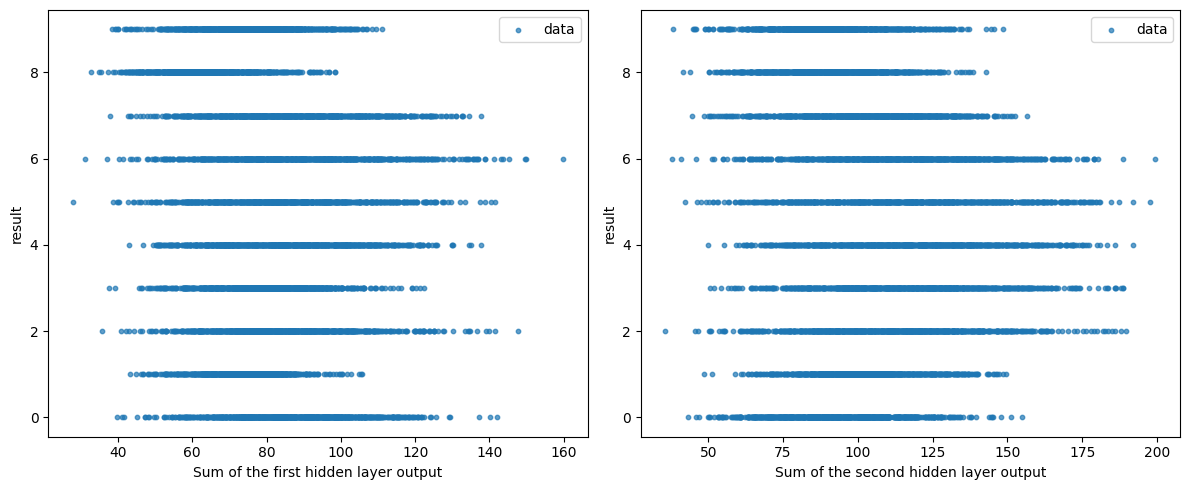

In [3]:
import matplotlib.pyplot as plt

# hidden1_outputs, hidden2_outputs: 각 히든 레이어의 출력값 (예: (10000, 300), (10000, 100))
# test_labels: (10000,)

# 첫 번째 히든 레이어 출력값 합
hidden1_sum = np.sum(hidden1_outputs, axis=1)  # (10000,)
# 두 번째 히든 레이어 출력값 합
hidden2_sum = np.sum(hidden2_outputs, axis=1)  # (10000,)

plt.figure(figsize=(12, 5))

# 첫 번째 히든 레이어 출력값 합 vs 라벨
plt.subplot(1, 2, 1)
plt.scatter(hidden1_sum, test_labels, label='data', alpha=0.7, s=10)
plt.xlabel('Sum of the first hidden layer output')
plt.ylabel('result')
plt.legend()

# 두 번째 히든 레이어 출력값 합 vs 라벨
plt.subplot(1, 2, 2)
plt.scatter(hidden2_sum, test_labels, label='data', alpha=0.7, s=10)
plt.xlabel('Sum of the second hidden layer output')
plt.ylabel('result')
plt.legend()

plt.tight_layout()
plt.show()

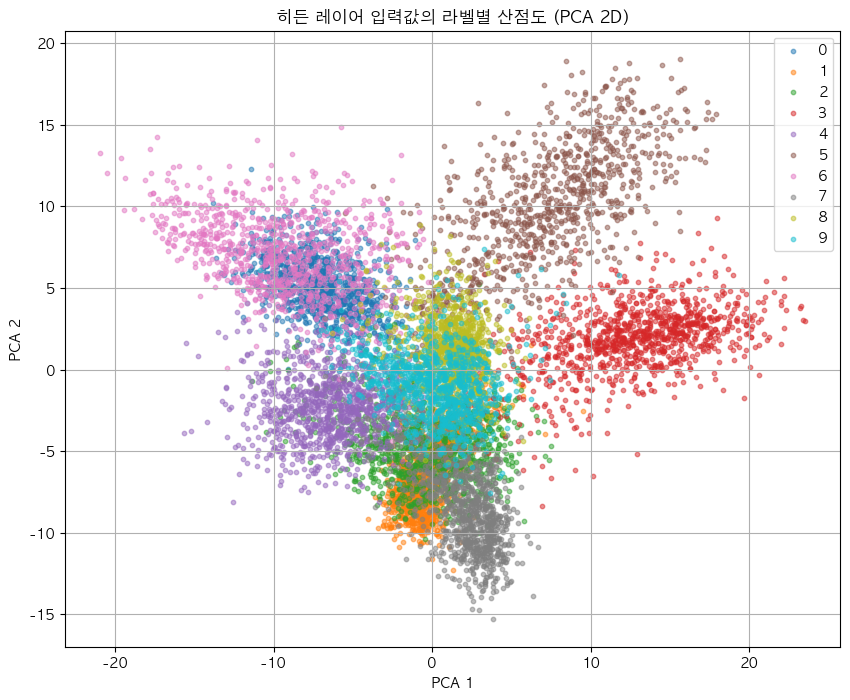

In [4]:
from sklearn.decomposition import PCA
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

# output_inputs: (10000, 100), test_labels: (10000,)

# PCA로 2차원으로 축소
pca = PCA(n_components=2)
output_2d = pca.fit_transform(output_inputs)  # (10000, 2)

plt.figure(figsize=(10, 8))
for label in range(10):
    idx = test_labels == label
    plt.scatter(output_2d[idx, 0], output_2d[idx, 1], label=str(label), alpha=0.5, s=10)

plt.legend()
plt.title("히든 레이어 입력값의 라벨별 산점도 (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

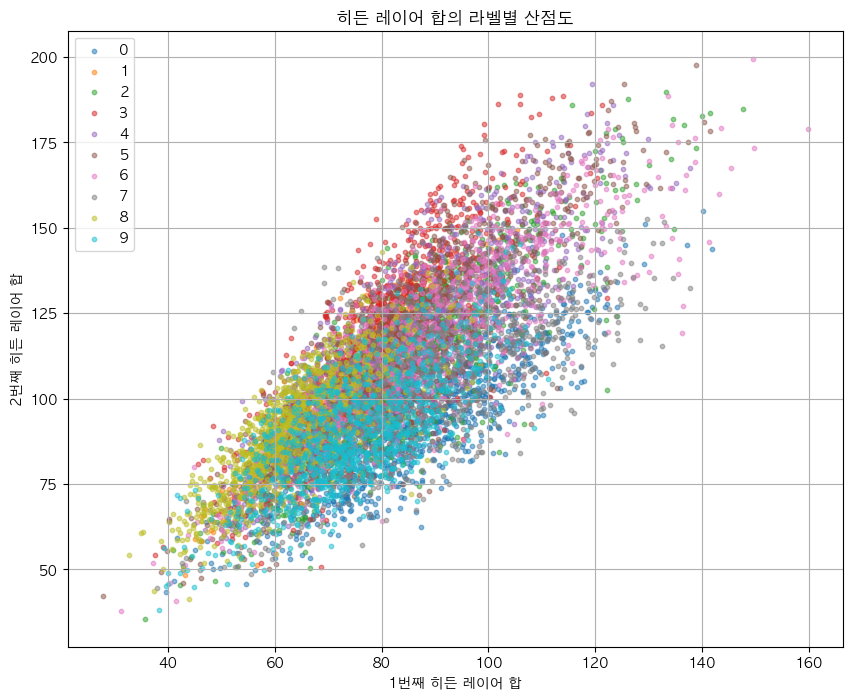

In [5]:
plt.figure(figsize=(10, 8))

# 각 샘플별로 합 구하기
hidden_sum1 = hidden1_outputs.sum(axis=1)  # (샘플수,)
hidden_sum2 = hidden2_outputs.sum(axis=1)  # (샘플수,)

for label in range(10):
    idx = test_labels == label
    plt.scatter(hidden_sum1[idx], hidden_sum2[idx], label=str(label), alpha=0.5, s=10)

plt.legend()
plt.title("히든 레이어 합의 라벨별 산점도")
plt.xlabel("1번째 히든 레이어 합")
plt.ylabel("2번째 히든 레이어 합")
plt.grid(True)
plt.show()